In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csr_array
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data

from cci.utils import get_adata
from cci.data import dataset_application_poster, save_application_experiment, load_application_experiment
from cci.models import MultilayerNode2Vec

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /allen/programs/celltypes/workgroups/mousecelltypes/Rohan/env/miniconda3/envs/pygnode2vec/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "

In [2]:
case = "independent"

with timebudget("loading data"):
    data, df, graph_hparams = dataset_application_poster(case=case)

loading data took 5.813sec


In [3]:
# MultilayerNode2vec hyperparameters
n2v_params = dict(
    p=1.0,
    q=1.0,
    embedding_dim=3,
    walk_length=10,
    context_size=10,
    walks_per_node=1,
    num_negative_samples_per_layer=1,
    num_nodes=graph_hparams["num_nodes"],
    batch_size=128,
)

device = "cpu"
model_dict = {}
loader_dict = {}
optimizer_dict = {}
for i in range(graph_hparams["n_layers"]):
    model_dict[i] = MultilayerNode2Vec(data.edge_index_list, **n2v_params, sparse=True).to(device)
    loader_dict[i] = model_dict[i].loader(batch_size=n2v_params["batch_size"], shuffle=True)
    optimizer_dict[i] = torch.optim.SparseAdam(list(model_dict[i].parameters()), lr=0.01)


def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def get_z(model_dict):
    z_list = [None] * len(model_dict.values())
    for i, model in enumerate(model_dict.values()):
        model.eval()
        z_list[i] = model()
        z_list[i] = z_list[i].detach().cpu().numpy()
    z = np.concatenate(z_list, axis=1)
    del z_list
    return z


@torch.no_grad()
def test(model_dict):
    z = get_z(model_dict)
    clf = LogisticRegression().fit(z[data.train_idx], data.labels[data.train_idx])
    acc_test = clf.score(z[data.test_idx], data.labels[data.test_idx])
    keep_idx = np.concatenate([data.train_idx, data.test_idx])
    acc_overall = clf.score(z[keep_idx], data.labels[keep_idx])
    return acc_test, acc_overall


def show_embeddings(z, df, savepath=None):
    if savepath is not None:
        assert savepath.endswith(".png"), "savepath should end with .png"
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_tsne = tsne.fit_transform(z)

    keep = df["participant"].values
    subclass_color_dict = df[["subclass_color", "subclass"]].drop_duplicates()
    subclass_color_dict = subclass_color_dict.set_index("subclass").to_dict()["subclass_color"]
    f, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(
        x=z_tsne[keep, 0],
        y=z_tsne[keep, 1],
        hue=df["subclass"][keep],
        palette=subclass_color_dict,
        s=5,
        linewidth=0,
        ax=ax,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_subclass.png"), dpi=300)
    else:
        plt.show()

    f, ax = plt.subplots(figsize=(5, 5))
    participant_color_dict = {True: "darkgrey", False: "whitesmoke"}
    sns.scatterplot(
        x=z_tsne[:, 0], y=z_tsne[:, 1], hue=df["participant"], palette=participant_color_dict, s=3, linewidth=0, ax=ax
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.axis("off")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath.replace(".png", "_participant.png"), dpi=300)
    else:
        plt.show()

    plt.show()
    return z_tsne

Epoch: 010, Loss: 5.5022, Test accuracy: 0.2298, Overall accuracy: 0.2518
Epoch: 020, Loss: 5.2119, Test accuracy: 0.2510, Overall accuracy: 0.2810
Epoch: 030, Loss: 5.0731, Test accuracy: 0.2831, Overall accuracy: 0.3011
Epoch: 040, Loss: 5.0068, Test accuracy: 0.2941, Overall accuracy: 0.3073
Epoch: 050, Loss: 4.9587, Test accuracy: 0.3051, Overall accuracy: 0.3152
Epoch: 060, Loss: 4.9419, Test accuracy: 0.3129, Overall accuracy: 0.3243
Epoch: 070, Loss: 4.9245, Test accuracy: 0.3122, Overall accuracy: 0.3306
Epoch: 080, Loss: 4.9175, Test accuracy: 0.3122, Overall accuracy: 0.3321
Epoch: 090, Loss: 4.9099, Test accuracy: 0.3200, Overall accuracy: 0.3394
Epoch: 100, Loss: 4.9033, Test accuracy: 0.3216, Overall accuracy: 0.3386
Epoch: 110, Loss: 4.8963, Test accuracy: 0.3216, Overall accuracy: 0.3441
Epoch: 120, Loss: 4.8915, Test accuracy: 0.3310, Overall accuracy: 0.3453
Epoch: 130, Loss: 4.8920, Test accuracy: 0.3286, Overall accuracy: 0.3469
Epoch: 140, Loss: 4.8861, Test accurac

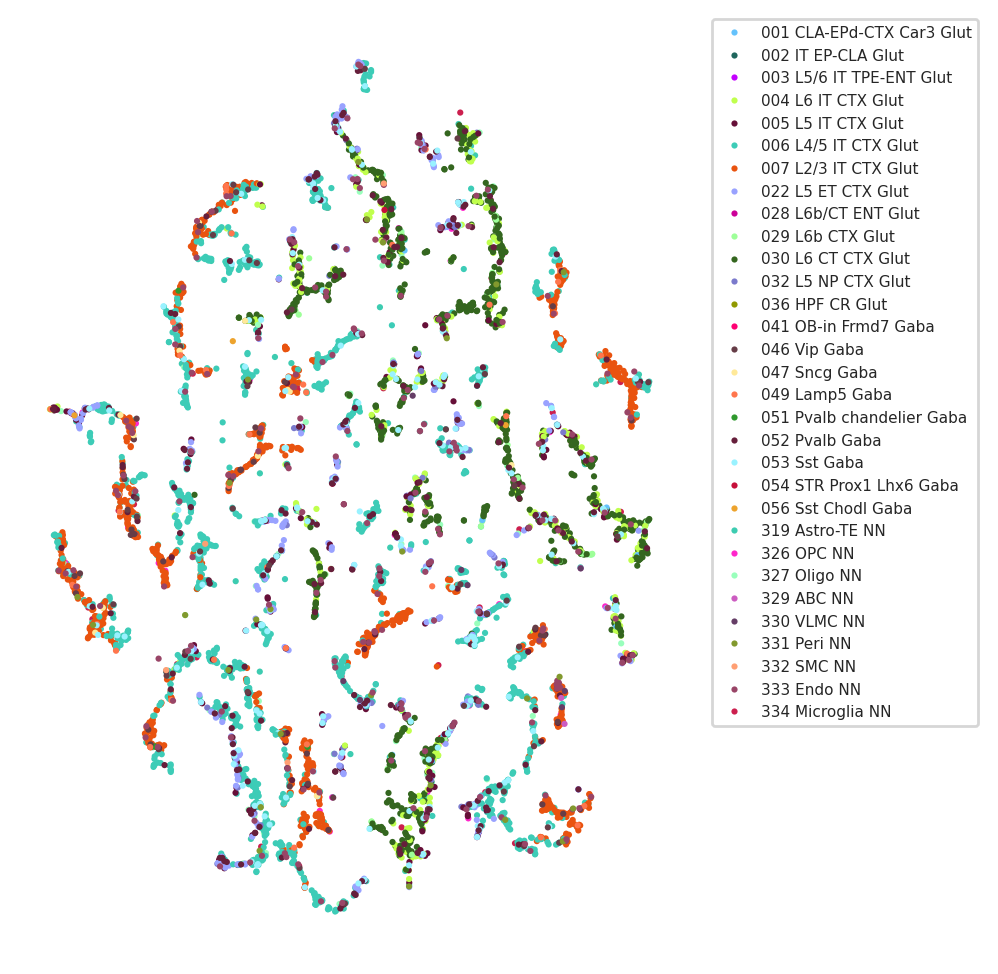

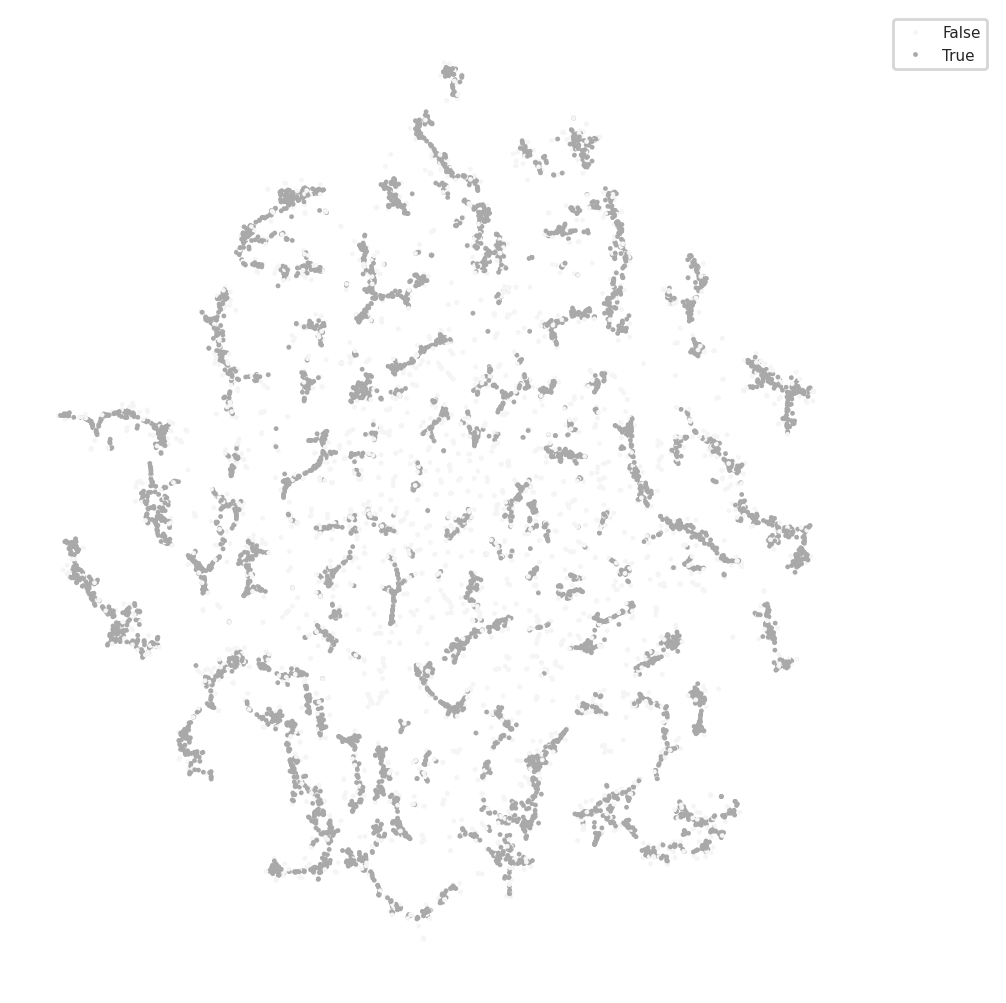

Epoch: 210, Loss: 4.8793, Test accuracy: 0.3490, Overall accuracy: 0.3649
Epoch: 220, Loss: 4.8783, Test accuracy: 0.3443, Overall accuracy: 0.3659
Epoch: 230, Loss: 4.8753, Test accuracy: 0.3529, Overall accuracy: 0.3652
Epoch: 240, Loss: 4.8802, Test accuracy: 0.3514, Overall accuracy: 0.3701
Epoch: 250, Loss: 4.8785, Test accuracy: 0.3655, Overall accuracy: 0.3783
Epoch: 260, Loss: 4.8738, Test accuracy: 0.3553, Overall accuracy: 0.3769
Epoch: 270, Loss: 4.8737, Test accuracy: 0.3608, Overall accuracy: 0.3789
Epoch: 280, Loss: 4.8751, Test accuracy: 0.3655, Overall accuracy: 0.3813
Epoch: 290, Loss: 4.8720, Test accuracy: 0.3624, Overall accuracy: 0.3833
Epoch: 300, Loss: 4.8743, Test accuracy: 0.3741, Overall accuracy: 0.3824
Epoch: 310, Loss: 4.8729, Test accuracy: 0.3718, Overall accuracy: 0.3838
Epoch: 320, Loss: 4.8720, Test accuracy: 0.3741, Overall accuracy: 0.3853
Epoch: 330, Loss: 4.8680, Test accuracy: 0.3757, Overall accuracy: 0.3869
Epoch: 340, Loss: 4.8691, Test accurac

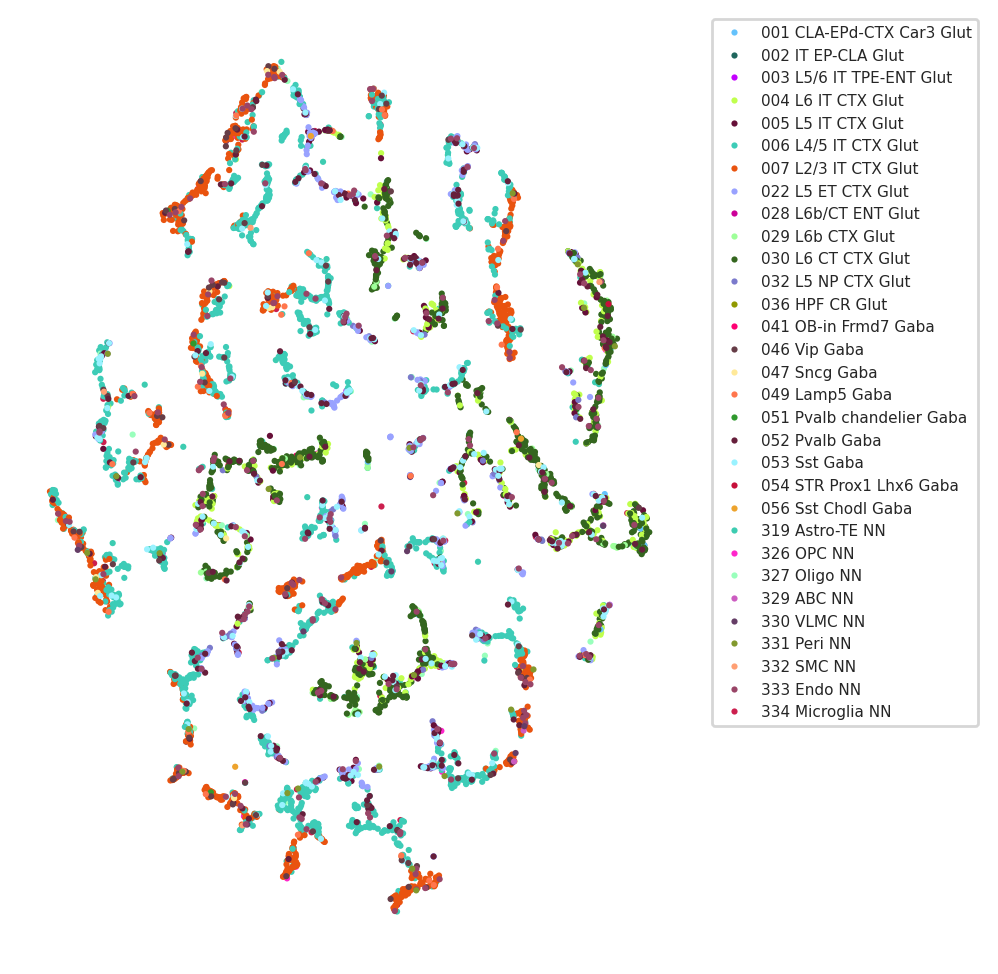

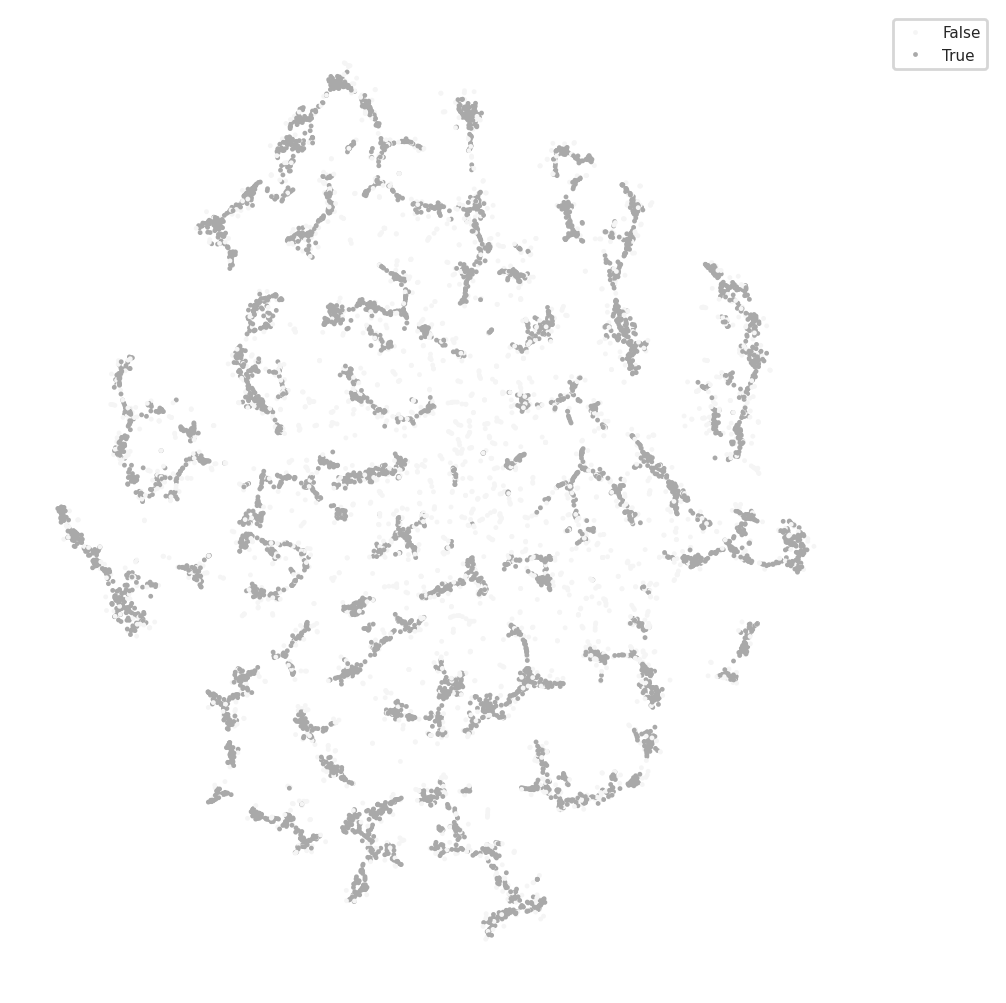

Epoch: 410, Loss: 4.8691, Test accuracy: 0.3843, Overall accuracy: 0.3926
Epoch: 420, Loss: 4.8707, Test accuracy: 0.3835, Overall accuracy: 0.3921
Epoch: 430, Loss: 4.8729, Test accuracy: 0.3804, Overall accuracy: 0.3924
Epoch: 440, Loss: 4.8682, Test accuracy: 0.3804, Overall accuracy: 0.3915
Epoch: 450, Loss: 4.8659, Test accuracy: 0.3820, Overall accuracy: 0.3924
Epoch: 460, Loss: 4.8690, Test accuracy: 0.3780, Overall accuracy: 0.3905
Epoch: 470, Loss: 4.8656, Test accuracy: 0.3835, Overall accuracy: 0.3924
Epoch: 480, Loss: 4.8696, Test accuracy: 0.3820, Overall accuracy: 0.3904
Epoch: 490, Loss: 4.8654, Test accuracy: 0.3827, Overall accuracy: 0.3944
Epoch: 500, Loss: 4.8626, Test accuracy: 0.3859, Overall accuracy: 0.3941
Epoch: 510, Loss: 4.8628, Test accuracy: 0.3804, Overall accuracy: 0.3952
Epoch: 520, Loss: 4.8659, Test accuracy: 0.3796, Overall accuracy: 0.3954
Epoch: 530, Loss: 4.8622, Test accuracy: 0.3867, Overall accuracy: 0.3955
Epoch: 540, Loss: 4.8640, Test accurac

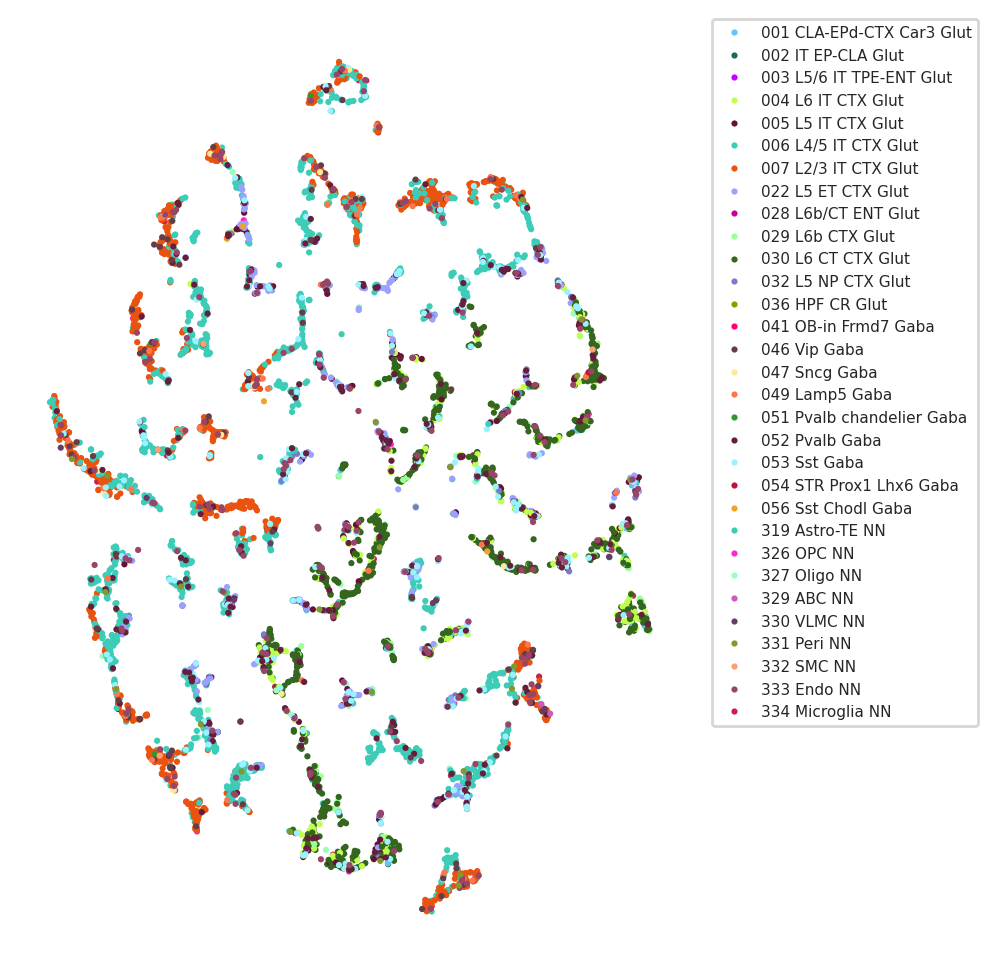

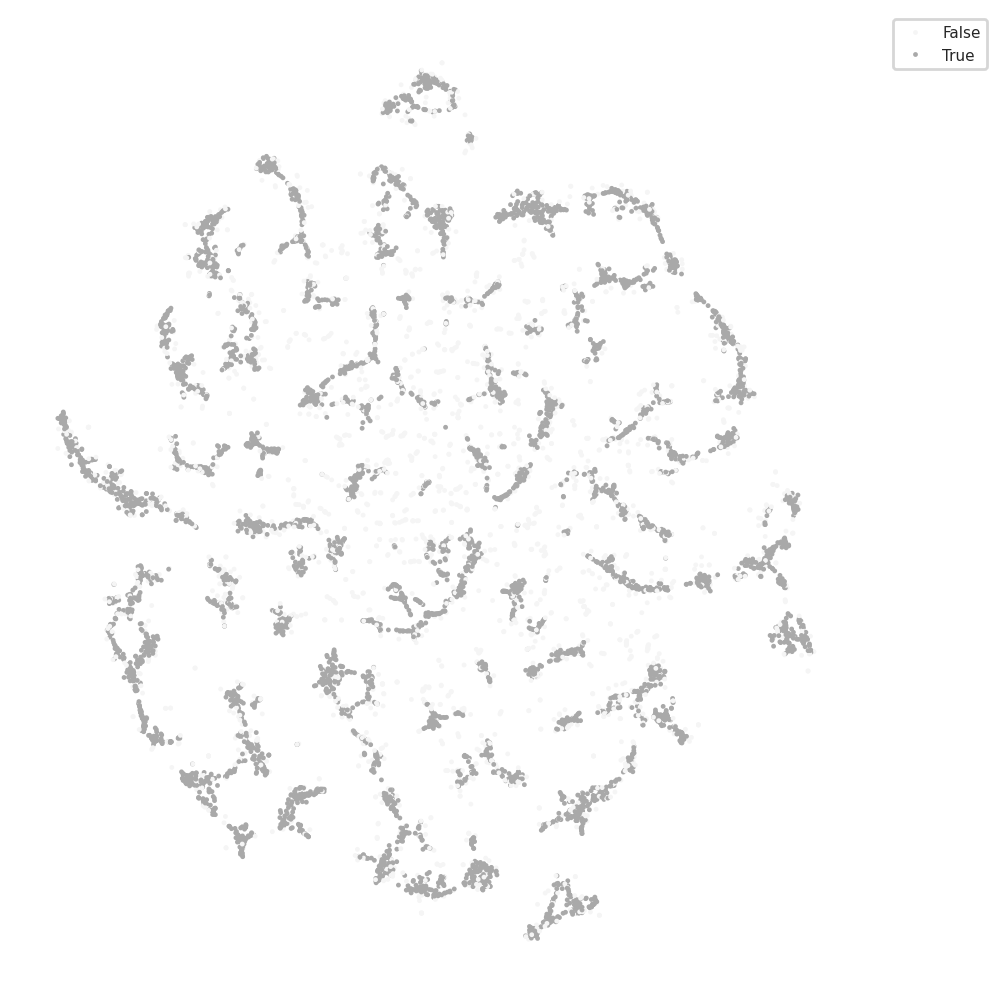

Epoch: 610, Loss: 4.8628, Test accuracy: 0.3914, Overall accuracy: 0.3974
Epoch: 620, Loss: 4.8610, Test accuracy: 0.3953, Overall accuracy: 0.3990
Epoch: 630, Loss: 4.8588, Test accuracy: 0.3961, Overall accuracy: 0.3971
Epoch: 640, Loss: 4.8556, Test accuracy: 0.3906, Overall accuracy: 0.3977
Epoch: 650, Loss: 4.8609, Test accuracy: 0.3906, Overall accuracy: 0.3988
Epoch: 660, Loss: 4.8551, Test accuracy: 0.3961, Overall accuracy: 0.3987
Epoch: 670, Loss: 4.8554, Test accuracy: 0.3890, Overall accuracy: 0.3990
Epoch: 680, Loss: 4.8557, Test accuracy: 0.3953, Overall accuracy: 0.4003
Epoch: 690, Loss: 4.8583, Test accuracy: 0.3914, Overall accuracy: 0.4010
Epoch: 700, Loss: 4.8568, Test accuracy: 0.3898, Overall accuracy: 0.3982
Epoch: 710, Loss: 4.8550, Test accuracy: 0.3992, Overall accuracy: 0.4018
Epoch: 720, Loss: 4.8587, Test accuracy: 0.3953, Overall accuracy: 0.4004
Epoch: 730, Loss: 4.8540, Test accuracy: 0.3929, Overall accuracy: 0.4018
Epoch: 740, Loss: 4.8548, Test accurac

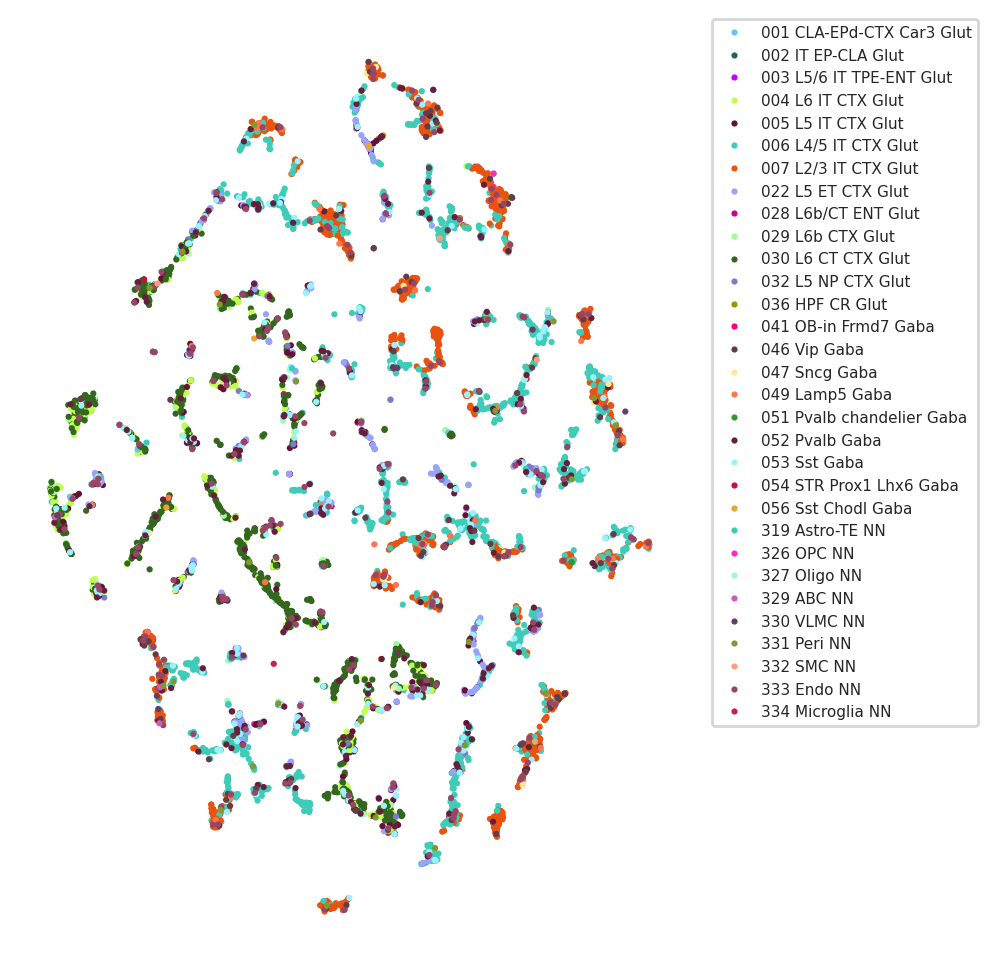

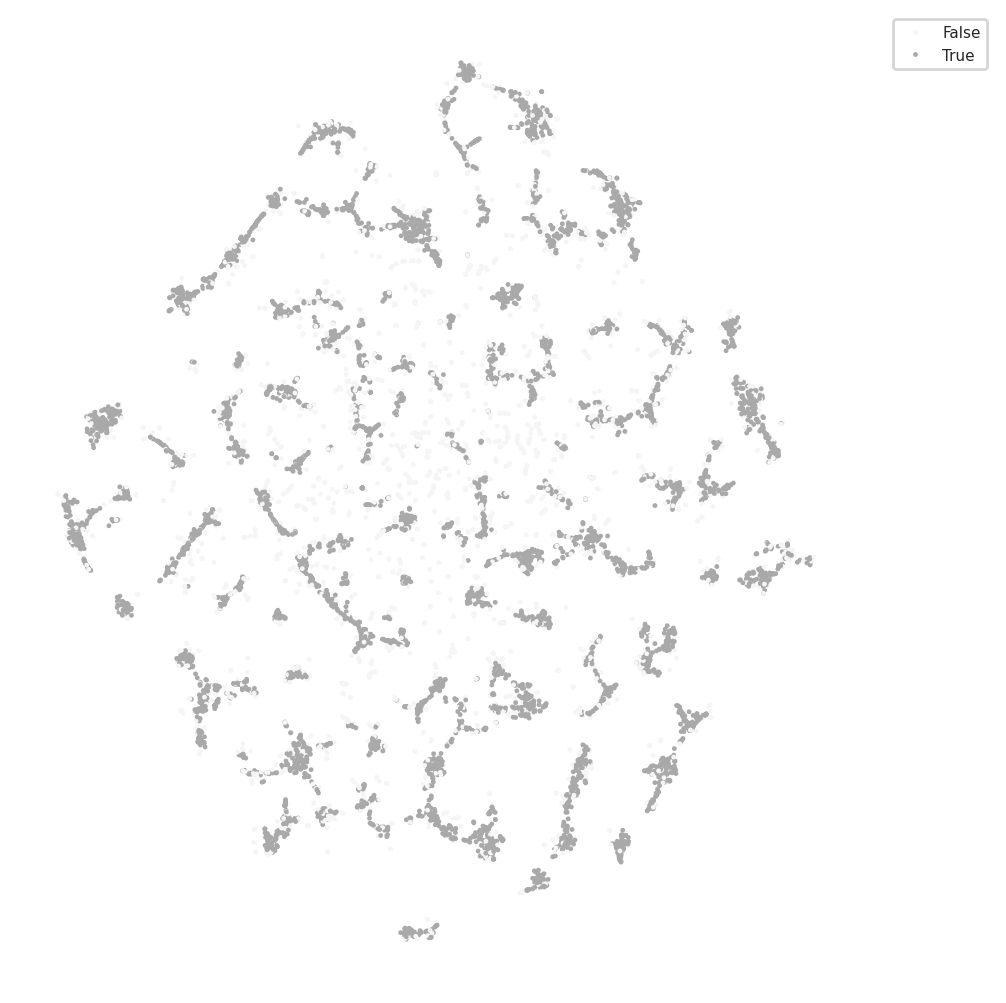

Epoch: 810, Loss: 4.8565, Test accuracy: 0.3984, Overall accuracy: 0.4059
Epoch: 820, Loss: 4.8542, Test accuracy: 0.4008, Overall accuracy: 0.4057
Epoch: 830, Loss: 4.8528, Test accuracy: 0.4000, Overall accuracy: 0.4050
Epoch: 840, Loss: 4.8516, Test accuracy: 0.3992, Overall accuracy: 0.4059
Epoch: 850, Loss: 4.8563, Test accuracy: 0.4016, Overall accuracy: 0.4068
Epoch: 860, Loss: 4.8525, Test accuracy: 0.4000, Overall accuracy: 0.4062
Epoch: 870, Loss: 4.8512, Test accuracy: 0.4039, Overall accuracy: 0.4046
Epoch: 880, Loss: 4.8569, Test accuracy: 0.4000, Overall accuracy: 0.4054
Epoch: 890, Loss: 4.8539, Test accuracy: 0.3992, Overall accuracy: 0.4051
Epoch: 900, Loss: 4.8549, Test accuracy: 0.3961, Overall accuracy: 0.4061
Epoch: 910, Loss: 4.8519, Test accuracy: 0.3906, Overall accuracy: 0.4032
Epoch: 920, Loss: 4.8554, Test accuracy: 0.4000, Overall accuracy: 0.4065
Epoch: 930, Loss: 4.8537, Test accuracy: 0.3937, Overall accuracy: 0.4059
Epoch: 940, Loss: 4.8499, Test accurac

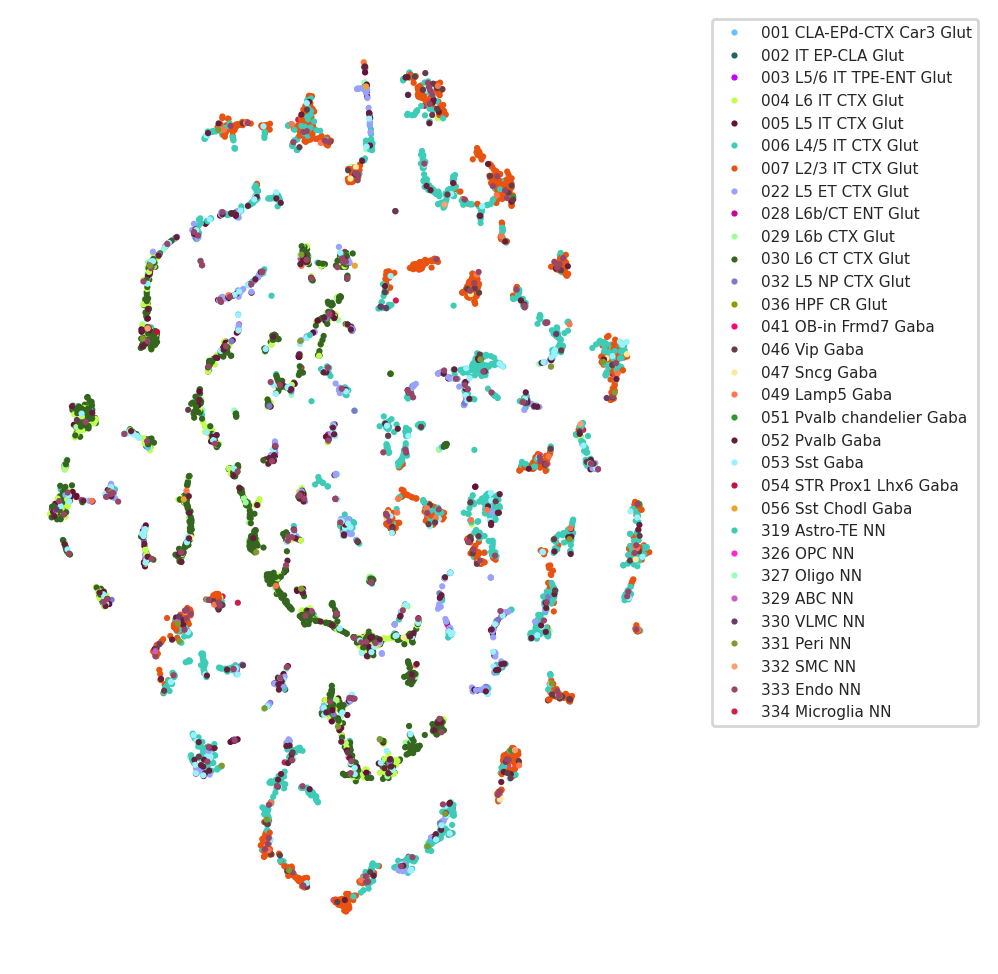

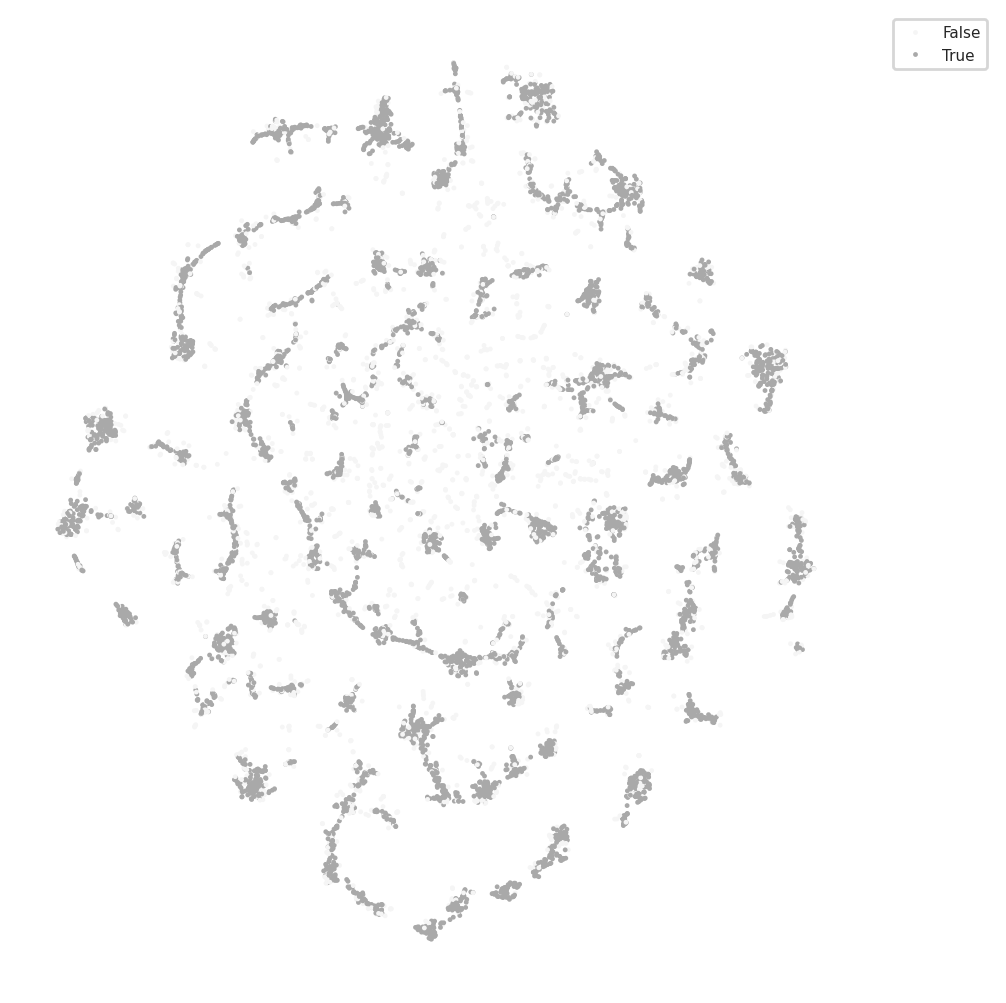

In [4]:
# model training:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    loss = [None] * graph_hparams["n_layers"]
    for i in range(graph_hparams["n_layers"]):
        loss[i] = train(model_dict[i], loader_dict[i], optimizer_dict[i])
    loss = sum(loss)

    if epoch % 10 == 0:
        acc_test, acc_overall = test(model_dict)
        print(
            f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test accuracy: {acc_test:.4f}, Overall accuracy: {acc_overall:.4f}"
        )
    if epoch % 200 == 0:
        print(f"Epoch: {epoch:03d} embeddings")
        z = get_z(model_dict)
        z_tsne = show_embeddings(z, df)
        fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
        save_application_experiment(
            fname=fname, epoch=epoch, z=z, df=df, graph_hparams=graph_hparams, leiden_partitions=None, z_tsne=z_tsne
        )

In [5]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph

100%|██████████| 6371/6371 [00:24<00:00, 264.05it/s]


Found 77 partitions


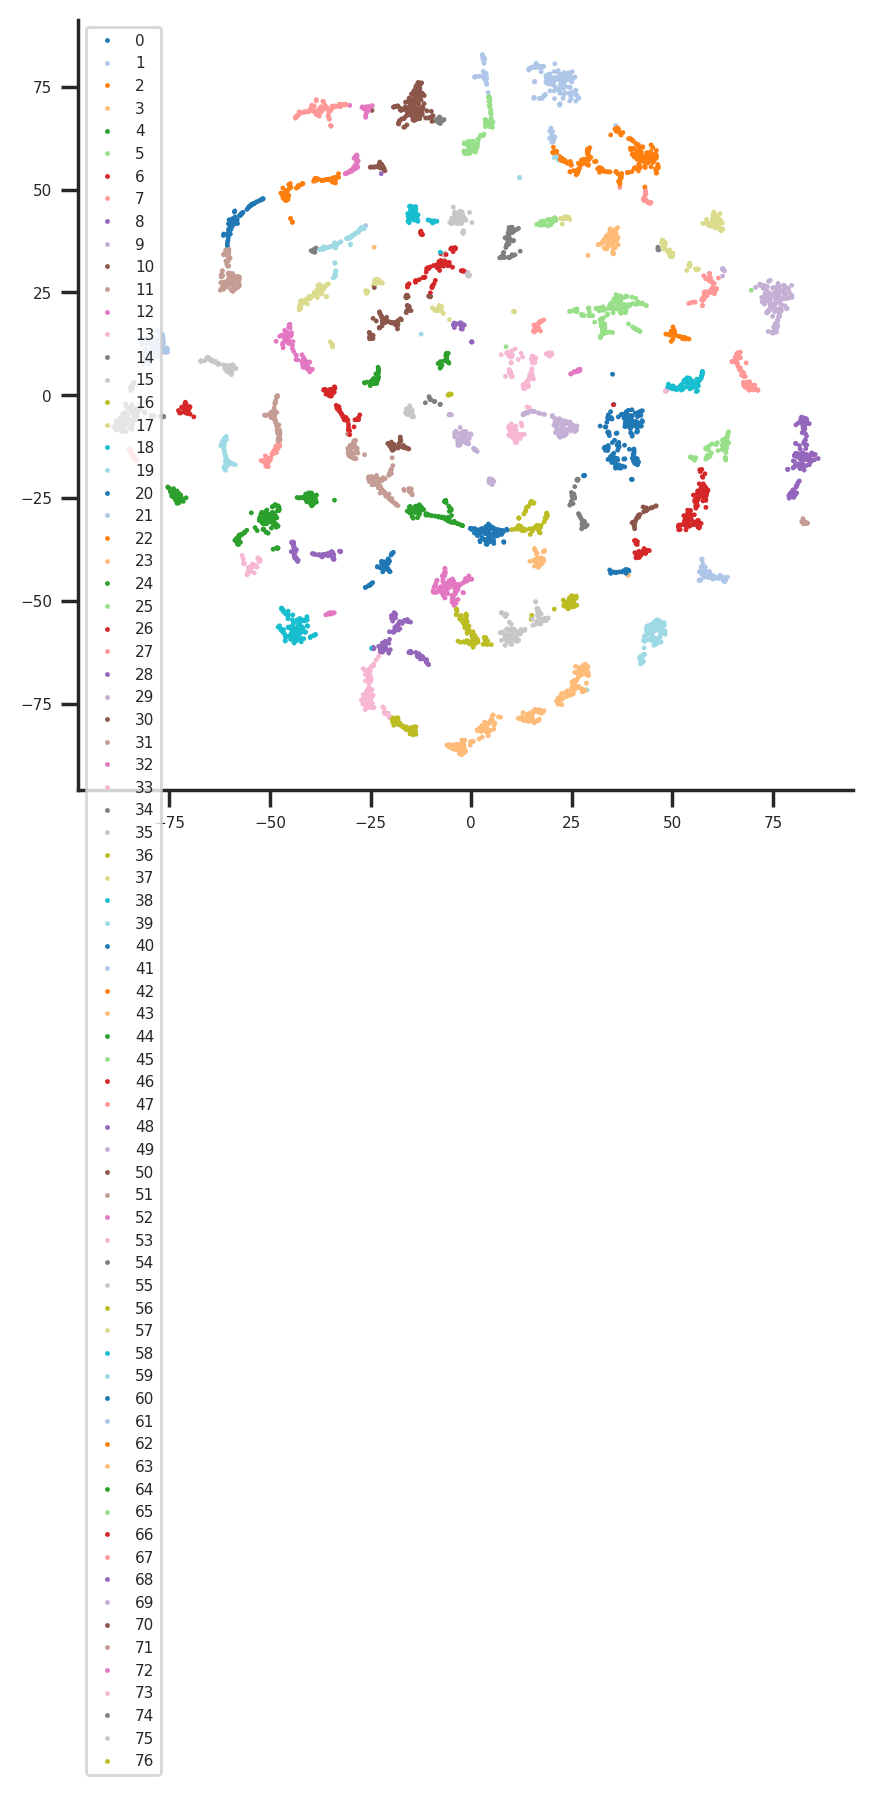

In [6]:
keep = df["participant"].values

# create a knn graph with z as positions
knn_graph = kneighbors_graph(z[keep], n_neighbors=5, mode="connectivity", include_self=False)

# convert to igraph
g = ig.Graph(directed=False)
g.add_vertices(knn_graph.shape[0])

for i in tqdm(range(knn_graph.shape[0])):
    for j in knn_graph[i].indices:
        g.add_edge(i, j)

# run leiden community detection
partition = la.find_partition(g, la.ModularityVertexPartition)
n_partitions = np.unique(partition.membership).size
print(f"Found {n_partitions} partitions")

# project labels on tsne
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(
    x=z_tsne[keep, 0], y=z_tsne[keep, 1], hue=partition.membership, palette="tab20", s=3, linewidth=0, ax=ax
)
plt.show()

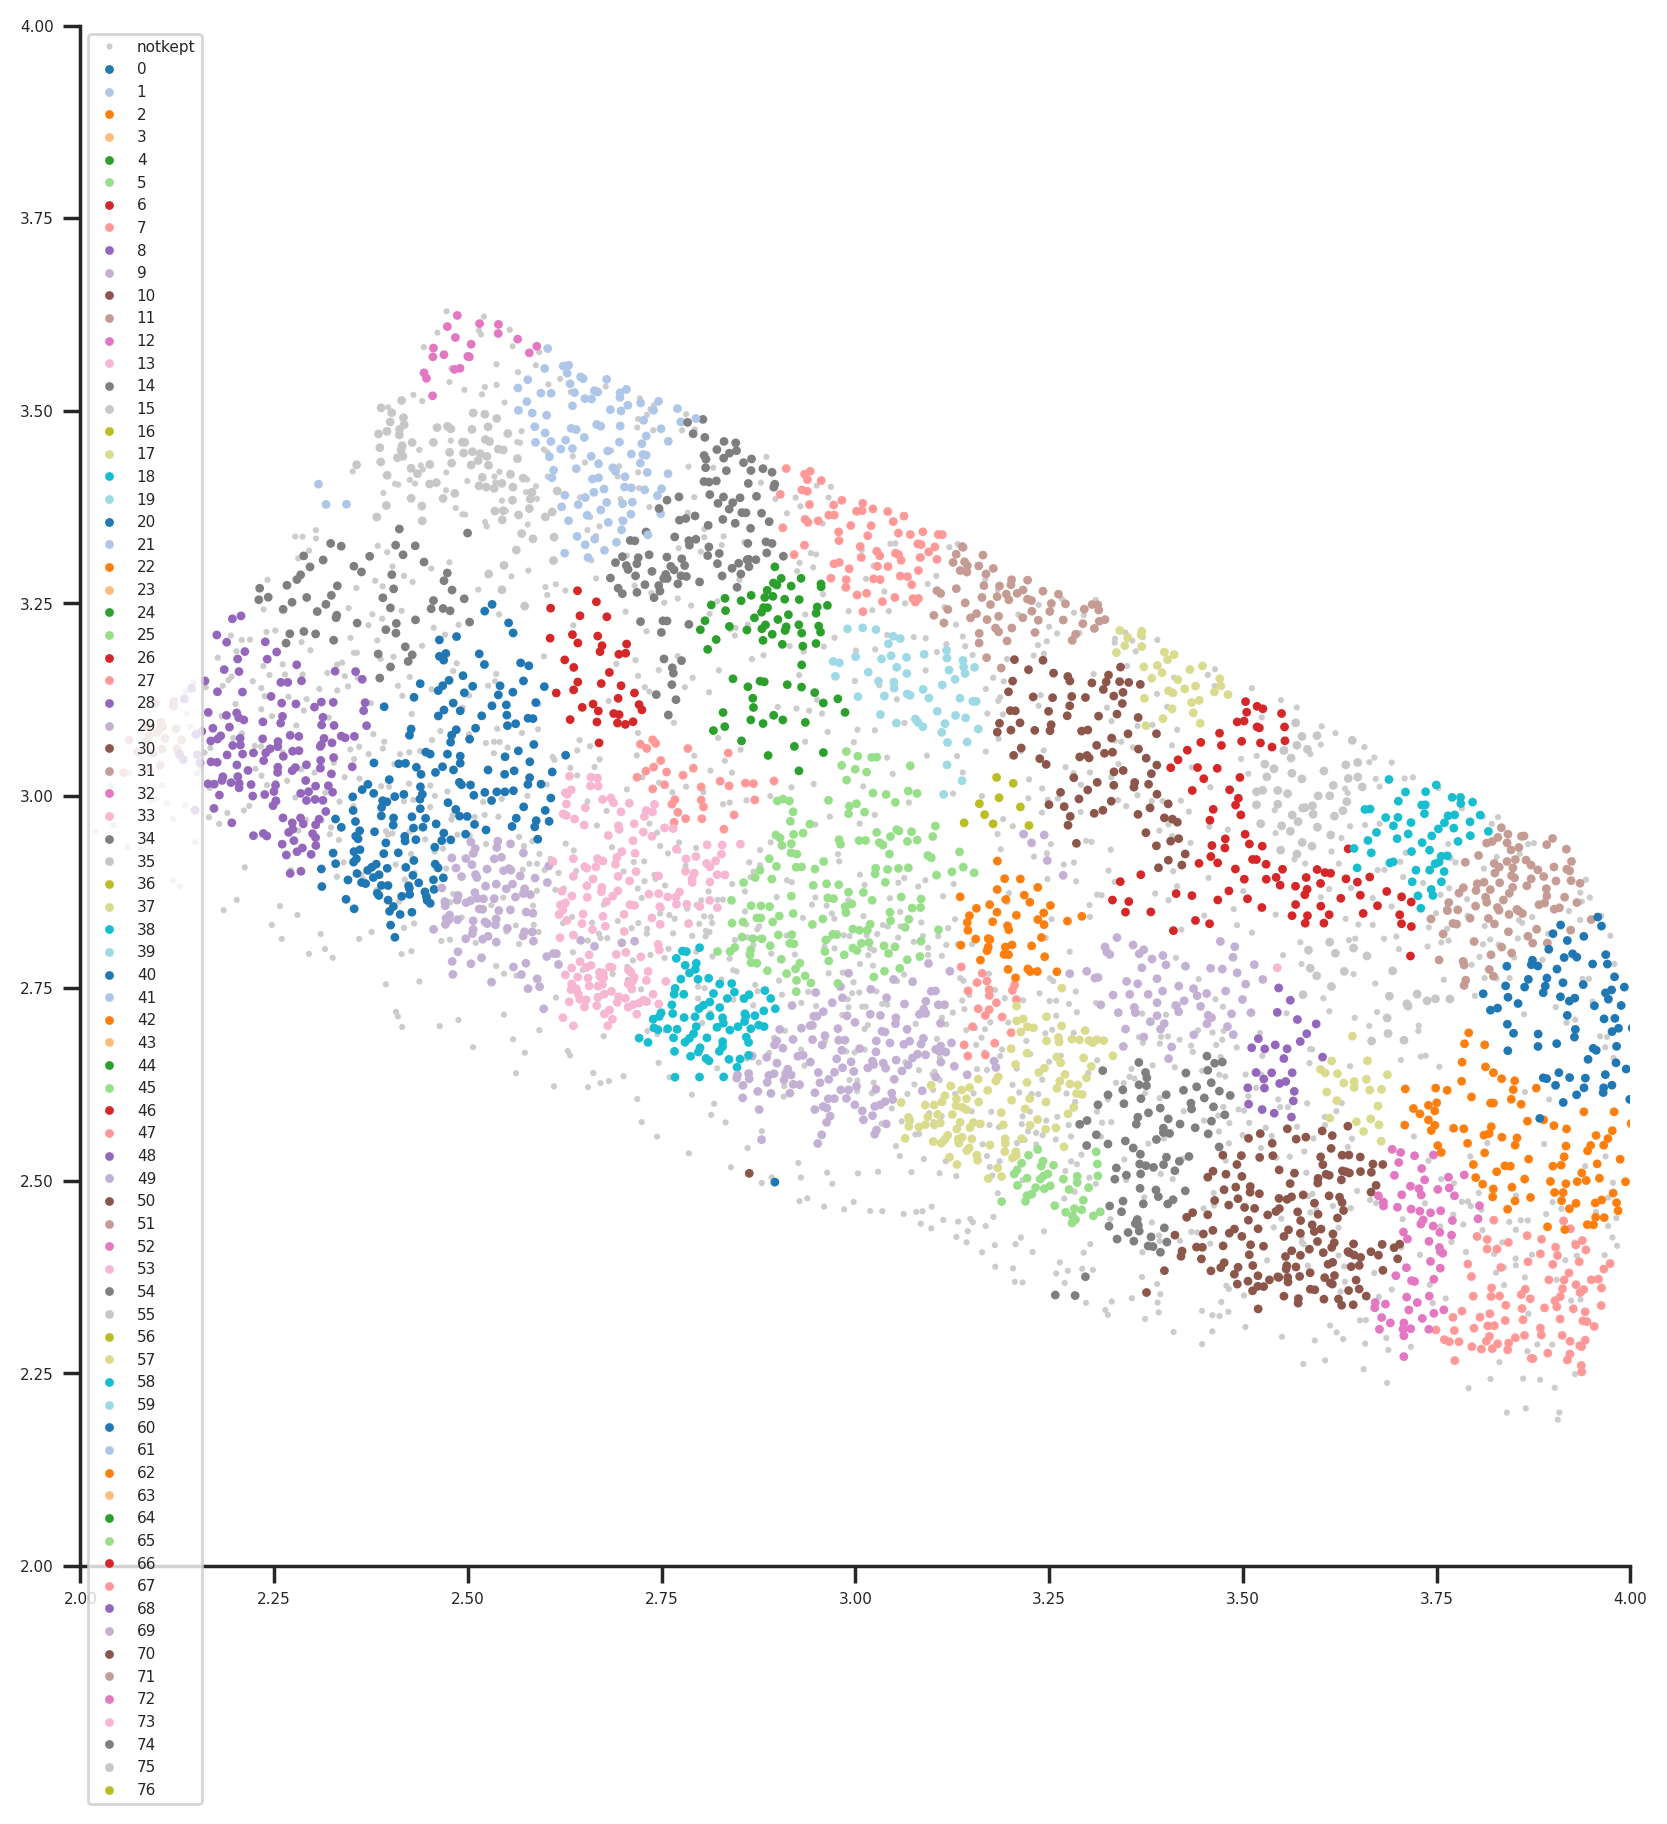

In [7]:
# project labels on brain co-ordinates
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=df["x_reconstructed"].values[~keep],
    y=df["y_reconstructed"].values[~keep],
    hue=np.array(["notkept"] * np.sum(~keep)),
    s=5,
    linewidth=0,
    ax=ax,
    palette=dict(notkept="#cccccc"),
)
sns.scatterplot(
    x=df["x_reconstructed"].values[keep],
    y=df["y_reconstructed"].values[keep],
    hue=partition.membership,
    palette="tab20",
    s=10,
    linewidth=0,
    ax=ax,
)
ax.set(ylim=(2, 4), xlim=(2, 4))
plt.show()

fname = f"case_{graph_hparams['case']}_epoch_{epoch:05d}.pkl"
save_application_experiment(
    fname=fname,
    epoch=epoch,
    z=z,
    df=df,
    graph_hparams=graph_hparams,
    n2v_params=n2v_params,
    leiden_partitions=partition.membership,
    z_tsne=z_tsne,
)